# Pupillometry data processing
This notebook is intended to document the process to set up a pipeline for pupil diameter acquisition.

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datajoint as dj
import os
import pathlib
import pandas as pd
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from skimage.measure import EllipseModel
from skimage.draw import ellipse_perimeter
from scipy import stats

In [3]:
dj.conn()
pupillometry_db = dj.create_virtual_module('pupillometry', 'u19_pupillometry')
acquisition_db = dj.create_virtual_module('acquisition', 'u19_acquisition')

Connecting alvaros@datajoint00.pni.princeton.edu:3306


### From which session we will get data (add a frame number as an example image)

In [4]:
frameNumber = 1000

key = dict()
key['subject_fullname'] = 'efonseca_ef111_act111'
key['session_date'] = '2023-06-24'

key

{'subject_fullname': 'efonseca_ef111_act111', 'session_date': '2023-06-24'}

### Get video & output paths

In [5]:
# Get video location
key_pupil = (acquisition_db.SessionVideo * pupillometry_db.PupillometrySession & key).fetch(as_dict=True)[0]
db_pupil_data = (pupillometry_db.PupillometrySessionModelData & key).fetch(as_dict=True)[0]
pupillometry_dir = dj.config.get('custom', {}).get('pupillometry_root_data_dir',None)
if pupillometry_dir is None:
    raise Exception('pupillometry_root_data_dir not found in config, run initial_conf.py again')
pupillometry_raw_dir = pupillometry_dir[0]
videoPath = pathlib.Path(pupillometry_raw_dir, key_pupil['remote_path_video_file'])
print('videoPath', videoPath)

# Get output location
pupillometry_processed_dir = pupillometry_dir[1]
output_dir = pathlib.Path(pupillometry_processed_dir,pathlib.Path(key_pupil['remote_path_video_file']).parent)

#Find h5 files (output from deeplabcut)
h5_files = glob.glob(str(output_dir) + '/*.h5')
if len(h5_files) != 1:
    raise Exception('Didn''t find any h5 files after deeplabcut analyze_video')
else:
    h5_files = h5_files[0]
print('h5_files', h5_files)

videoPath /Volumes/braininit/Data/Raw/video_pupillometry/efonseca/efonseca_ef111_act111/20230624_g0/efonseca_ef111_act111_20230624_g0.mrj.mj2
h5_files /Volumes/braininit/Data/Processed/video_pupillometry/efonseca/efonseca_ef111_act111/20230624_g0/efonseca_ef111_act111_20230624_g0.mrjDLC_resnet50_twolickspoutsJun22shuffle1_100000.h5


### Read videoFrame & h5 file

In [39]:
# Read output file
labels = pd.read_hdf(h5_files)


cap = cv2.VideoCapture(str(videoPath))

# count the number of frames 
frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) 

print('total # of frames', int(frames))
print('Length output deeplabcut', labels.shape[0])




total # of frames 108322
Length output deeplabcut 108322


In [41]:
# Get total number of frames
frameNumber = 997

totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES,frameNumber)

ret, frame = cap.read()



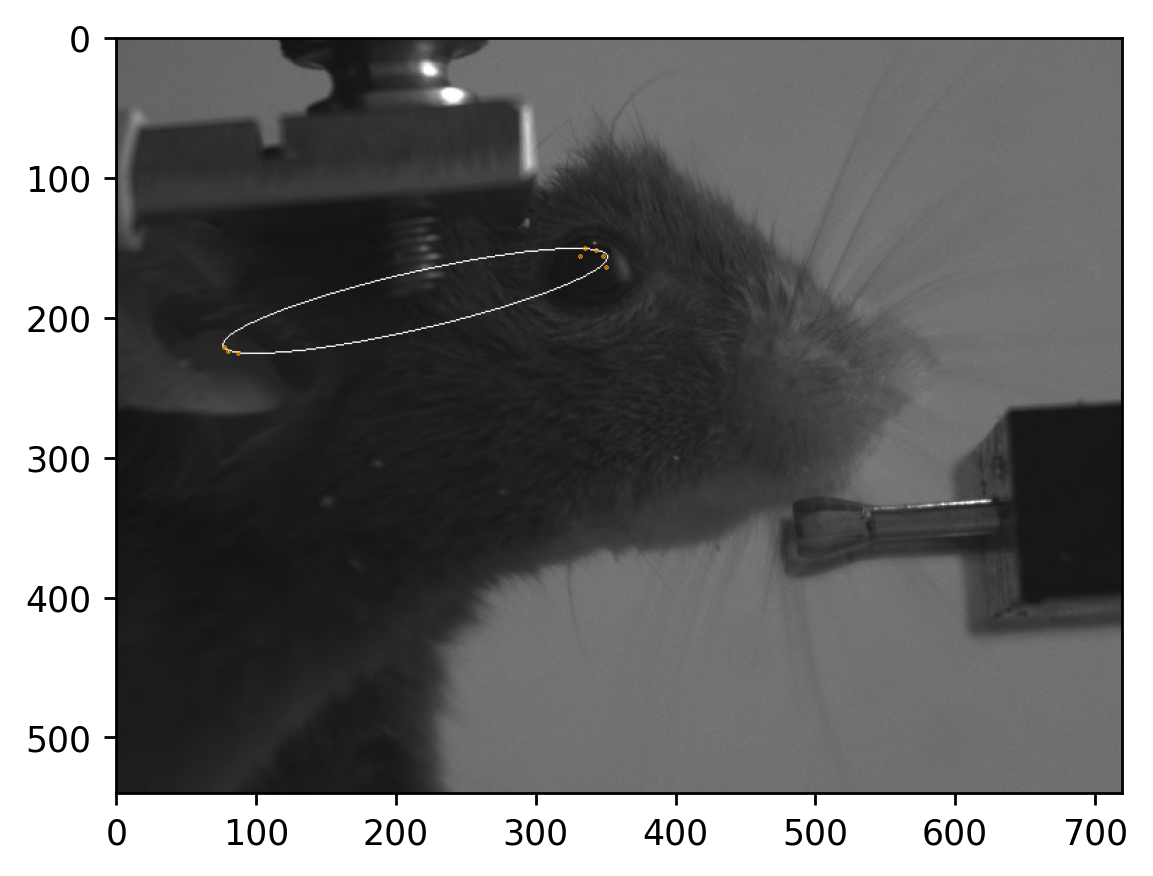

In [42]:


# Take a subset from the data
subset = labels.loc[frameNumber]
# Get the pupil markers (0 to 8) from the multiindex array obtained from deeplabcut
x = subset.xs('x', level='coords').to_numpy()[0:8]
y = subset.xs('y', level='coords').to_numpy()[0:8]
xy = np.column_stack((x,y))

# Estimate an ellipse based on the points generated around the pupil, this is enough to get an estimate of the pupil area in pixels
ellipse = EllipseModel()
ellipse.estimate(xy)

# Validate by ploting the points and the fitting ellipse on the image from the video
fig, ax = plt.subplots()
plt.rcParams['figure.dpi'] = 250
img = frame
ax.scatter(xy[:,0], xy[:,1], s=0.1, color='orange')
# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(int(ellipse.params[1]), int(ellipse.params[0]), int(ellipse.params[3]), int(ellipse.params[2]), ellipse.params[4])
img[cy, cx] = 255
ax.imshow(img)

# Calculate the area of the elipse
ellipseArea = np.pi * ellipse.params[2] * ellipse.params[3]

In [21]:
df = pd.DataFrame(db_pupil_data['pupil_diameter'], columns=['PupilDiameter'])

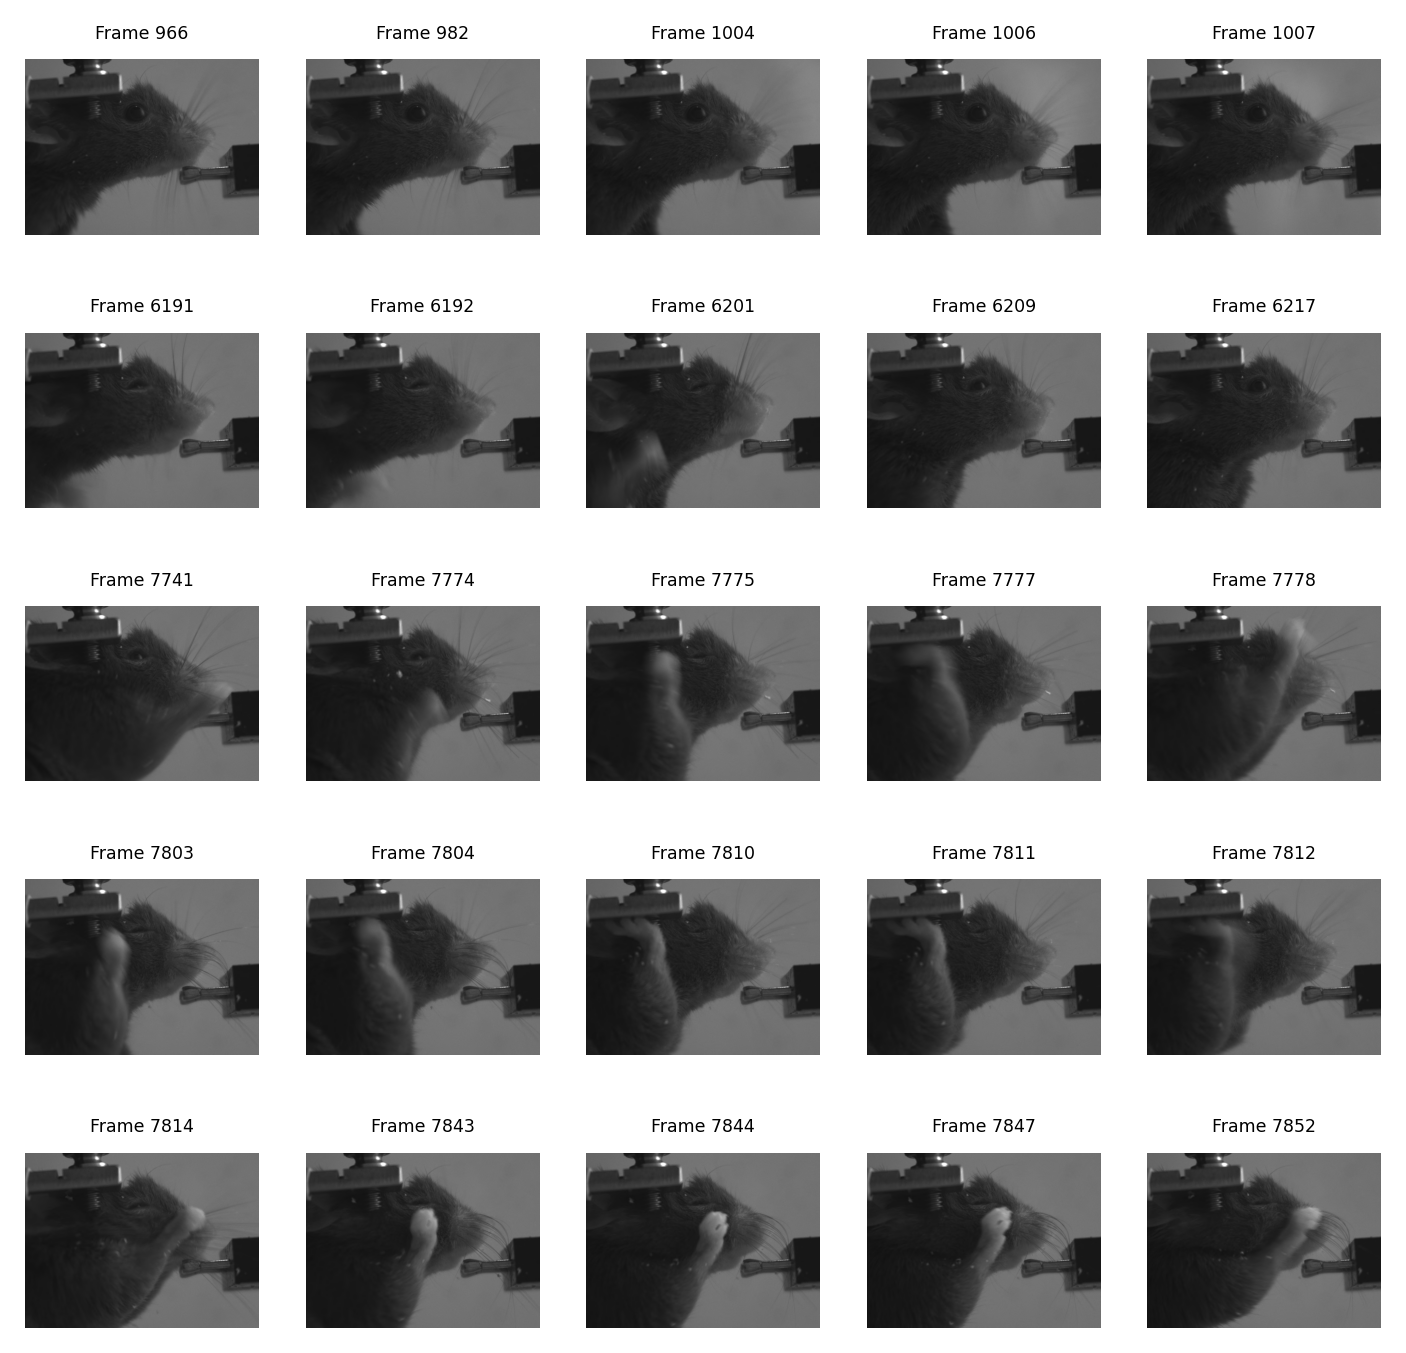

In [22]:

# Get a boolean array where true correspond to the frame with an outlier diameter
zscore = np.abs(stats.zscore(df, nan_policy='omit'))
outlierFlags = np.abs(zscore) > 2
outlierFlags = outlierFlags.rename(columns={outlierFlags.columns[0]: "OutlierFlag"})

# Get the list of outlier frames
from itertools import compress
outlierFrames = list(compress(range(len(outlierFlags)), outlierFlags['OutlierFlag']))


# Retrieve an outlier frames sample from the video for visual inspection
cap = cv2.VideoCapture(str(videoPath))
fig = plt.figure(figsize=(7, 7))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    # Get total number of frames
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES,outlierFrames[i])
    ret, frame = cap.read()

    fig.add_subplot(rows, columns, i)
    plt.title("Frame " + str(outlierFrames[i]), fontsize=5)
    plt.imshow(frame)
    plt.axis('off')
plt.show()
cap.release()
cv2.destroyAllWindows()


In [23]:
len(outlierFrames)

585

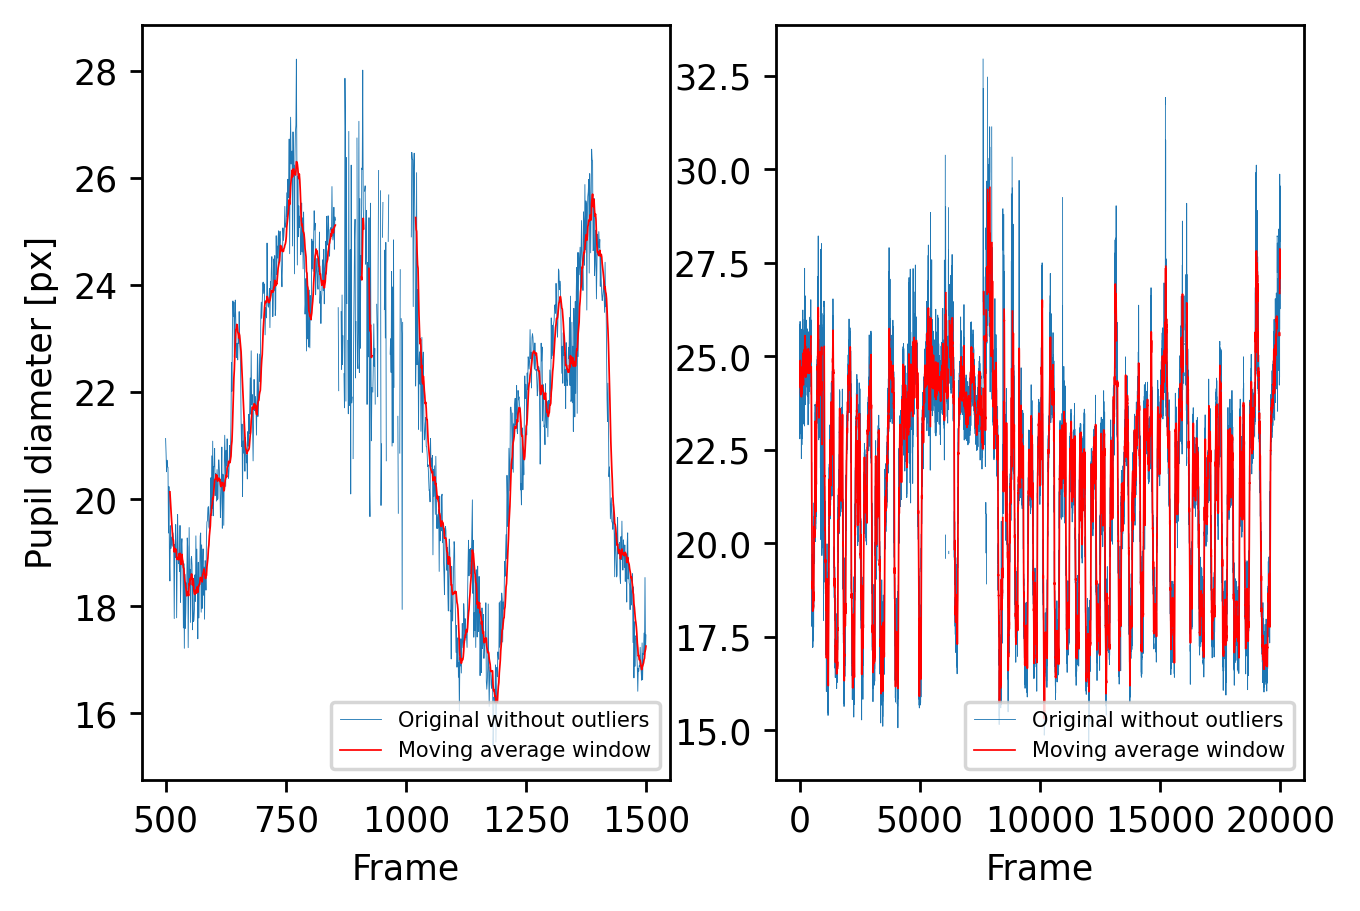

In [46]:
# Concatenate outlier flags array to remove outliers from pupil diameter array
temp = pd.concat([df, outlierFlags], axis=1)
temp.loc[temp['OutlierFlag']==True, 'PupilDiameter'] = None
pupilDiameter = temp['PupilDiameter']

# This might be better to leave open for the experimenter.
# Replace the outlier diameter data using a cubic spline interpolator
# pupilDiameter = temp['PupilDiameter'].interpolate(method='spline', order=3, s=0)

fig, (ax1, ax2) = plt.subplots(1,2)
# plt.rcParams['figure.dpi'] = 250

ax1.plot(pupilDiameter[500:1500], linewidth=0.25)
# Filter by using a moving average window of 10 samples
ax1.plot(pupilDiameter[500:1500].rolling(10).mean(), linewidth=0.5, color='red')
ax1.set_xlabel('Frame')
ax1.set_ylabel('Pupil diameter [px]')
ax1.legend(['Original without outliers', 'Moving average window'], loc=4, prop={'size': 6})

ax2.plot(pupilDiameter[0:20000], linewidth=0.25)
# Filter by using a moving average window of 10 samples
ax2.plot(pupilDiameter[0:20000].rolling(10).mean(), linewidth=0.5, color='red')
ax2.set_xlabel('Frame')
ax2.legend(['Original without outliers', 'Moving average window'], loc=4, prop={'size': 6})
#fig.savefig('test.eps', format='eps')

In [43]:
pupilDiameter[970:1030]

970     24.254245
971     20.993740
972     23.967066
973     21.054398
974     24.845345
975     22.090042
976           NaN
977     20.233948
978           NaN
979           NaN
980     24.978287
981           NaN
982           NaN
983     21.550476
984     19.738482
985           NaN
986           NaN
987     20.862419
988     24.289206
989           NaN
990     23.374079
991     23.096686
992     17.943278
993     23.305160
994           NaN
995     18.485246
996           NaN
997           NaN
998           NaN
999           NaN
1000          NaN
1001          NaN
1002          NaN
1003    17.951221
1004          NaN
1005    17.301645
1006          NaN
1007          NaN
1008    22.464462
1009          NaN
1010          NaN
1011    24.901657
1012    26.479977
1013    26.350696
1014    26.338709
1015    23.599777
1016    26.154361
1017    26.464175
1018    25.578285
1019    24.645074
1020    22.115321
1021    22.686392
1022    26.101115
1023    22.514810
1024    23.917634
1025    22